In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
import json
with open('data_schema_V2.0.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [5]:
df = pd.read_csv(f"data/processed/spectrometry_photometry.csv")

X = df[spectro_cols + photo_cols + generic_cols]
y = df[target_col]

In [6]:
# Define columns
spectro_cols = [
    "h_alpha_flux", "oiii_5007_flux", "nii_6584_flux",
    "sii_6717_flux", "lick_mgb", "lick_fe5335", "d4000", "velocityDisp"
]
photometry_cols = [
    "modelMag_u", "modelMag_r", "modelMag_z",
    "fracDev_r", "petroRad_r", "extinction_u", "extinction_r", "extinction_z"
]
generic_cols = ["z", "zErr"]
target_col = "logM_star"

# Feature matrix (X) and target (y)
feature_cols = spectro_cols + photometry_cols + generic_cols
X = df[feature_cols]
y = df[target_col]

In [7]:
# Fill missing values with median
X = X.fillna(X.median())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)


In [9]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score: {r2:.3f}")


Mean Absolute Error: 0.064
R² Score: 0.961


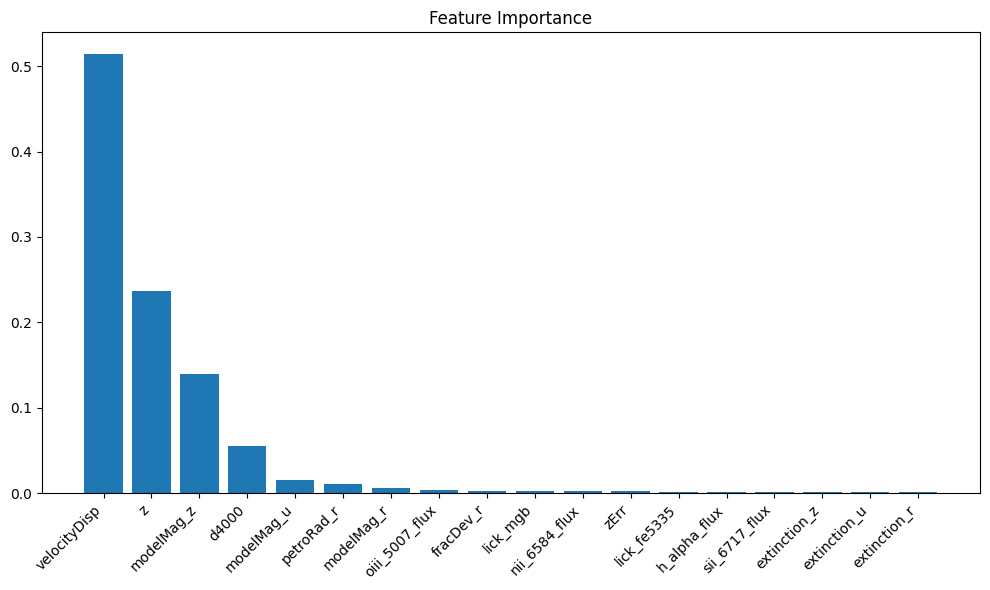

In [10]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx], align='center')
plt.xticks(range(len(importances)), np.array(feature_cols)[sorted_idx], rotation=45, ha='right')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


In [22]:
from util import *

In [12]:
plot_metrics(y_test, y_pred)

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.0641 dex
Root Mean Squared Error (RMSE): 0.1302 dex
R² Score: 0.9606
Fraction within ±0.20 dex: 94.40%


In [17]:
y_test.shape, y_pred.shape, X_test.shape

((44570,), (44570,), (44570, 18))

In [24]:
def plot_visualizations(y_test_flat, y_pred_flat, z_values=None, history=None):
    residuals = y_test_flat - y_pred_flat

    # Residual Plot
    plt.figure(figsize=(8, 5))
    if z_values is not None:
        scatter = plt.scatter(
            y_pred_flat,
            residuals,
            c=z_values,
            cmap='viridis',
            alpha=0.6,
            edgecolors='w',
            linewidth=0.3
        )
        plt.colorbar(scatter, label='Redshift (z)')
    else:
        sns.scatterplot(x=y_pred_flat, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot (Colored by Redshift)" if z_values is not None else "Residual Plot")
    plt.tight_layout()
    plt.show()

    # Parity Plot
    plt.figure(figsize=(8, 5))
    if z_values is not None:
        scatter = plt.scatter(
            y_test_flat,
            y_pred_flat,
            c=z_values,
            cmap='plasma',
            alpha=0.6,
            edgecolors='w',
            linewidth=0.3
        )
        plt.colorbar(scatter, label='Redshift (z)')
    else:
        sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Parity Plot (Colored by Redshift)" if z_values is not None else "Parity Plot")
    plt.tight_layout()
    plt.show()

    # Residual Distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.title("Distribution of Prediction Errors")
    plt.tight_layout()
    plt.show()

    if history is not None:
        # Determine if history is a dictionary or a Keras History object
        _history = None
        if isinstance(history, dict):
            _history = history
        elif hasattr(history, 'history'):
            _history = history.history
        else:
            raise ValueError("Invalid history object provided. It should be a dictionary or a Keras History object.")
        
        # Training vs Validation Loss
        plt.figure(figsize=(8, 4))
        plt.plot(_history['loss'], label='Training Loss', color='steelblue')
        plt.plot(_history['val_loss'], label='Validation Loss', color='salmon')
        plt.xlabel("Epochs")
        plt.ylabel("Mean Squared Error")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Training vs Validation MAE
        plt.figure(figsize=(8, 4))
        plt.plot(_history['mae'], label='Training MAE', color='darkgreen')
        plt.plot(_history['val_mae'], label='Validation MAE', color='orange')
        plt.xlabel("Epochs")
        plt.ylabel("Mean Absolute Error")
        plt.title("Training vs Validation MAE")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

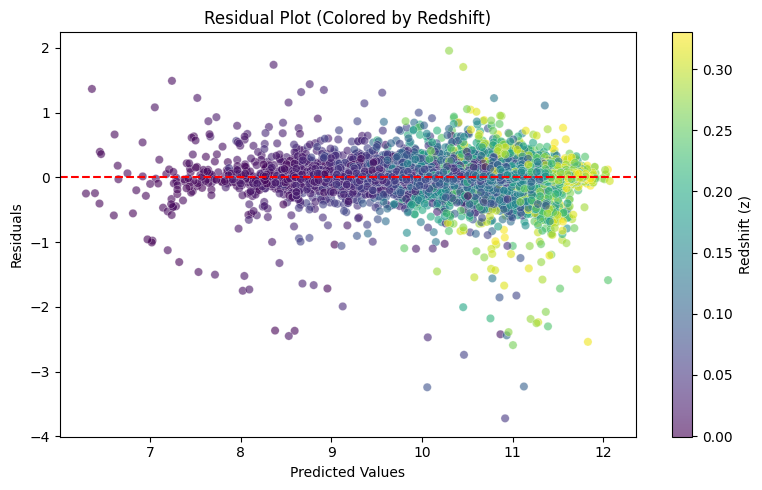

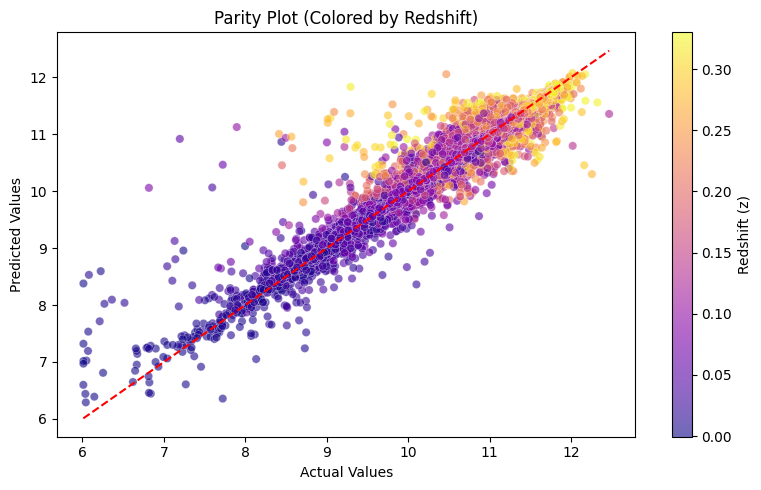

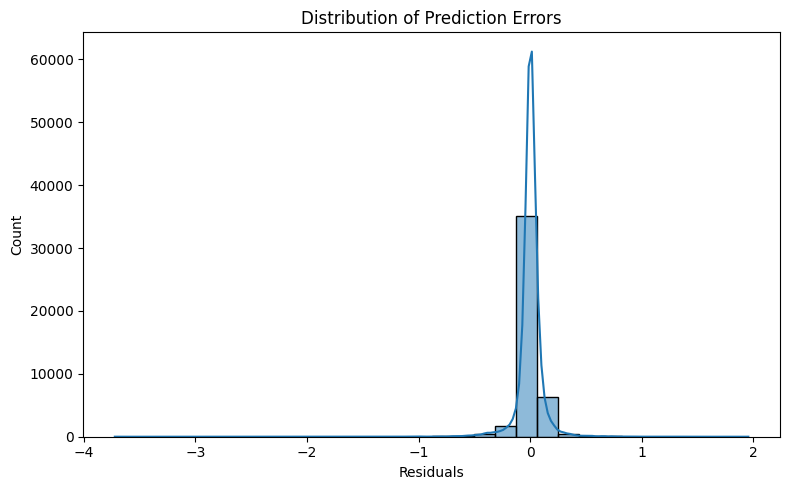

In [25]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'])